# Mimicking delusion: 

Mixing the error signals of different digits at the output level

In [1]:
import os
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from skimage.metrics import structural_similarity as ssim
from datetime import datetime
import csv
from sklearn.metrics import silhouette_score
import statistics

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

/Users/irismarmouset-delataille/mambaforge/envs/localglobal/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/irismarmouset-delataille/mambaforge/envs/localglobal/lib/python3.11/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <E03EDA44-89AE-3115-9796-62BA9E0E2EDE> /Users/irismarmouset-delataille/mambaforge/envs/localglobal/lib/python3.11/site-packages/torchvision/image.so
  Expected in:     <E943EB88-577E-37A4-93E1-5DAFE97B5744> /Users/irismarmouset-delataille/mambaforge/envs/localglobal/lib/python3.11/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


### Dataset

In [2]:
from dataset import get_mnist_dataset
working_directory = os.getcwd()
data_dir = os.path.join(working_directory, './dataset')
batch_size_train = 64
batch_size_test = 1000

train_data_loader, test_data_loader = get_mnist_dataset(data_dir, batch_size_train=batch_size_train, batch_size_test=batch_size_test)

print('Train dataset size: {}'.format(len(train_data_loader.dataset)))
print('Test dataset size: {}'.format(len(test_data_loader.dataset)))

Train dataset size: 60000
Test dataset size: 10000


### Model

In [55]:
from modules.network import PV_SST_Pyr

device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = PV_SST_Pyr(thal_input_dim = 784, latent_dim=16, output_dim=10, mix_signals=(0,1)).to(device)

print(model)
print(f"Model mix_signals: {model.mix_signals}")

PV_SST_Pyr(
  (encoder): encoder(
    (flatten): Flatten()
    (activation): Sigmoid()
    (fc1): Linear(in_features=784, out_features=16, bias=True)
  )
  (decoder): decoder(
    (activation): Sigmoid()
    (fc1): Linear(in_features=16, out_features=128, bias=True)
    (fc2): Linear(in_features=128, out_features=784, bias=True)
  )
  (classifier): classifier(
    (fc1): Linear(in_features=16, out_features=10, bias=True)
    (activation): Sigmoid()
  )
)
Model mix_signals: (0, 1)


In [56]:
for name, param in model.named_parameters():
    print (name)   

encoder.fc1.weight
encoder.fc1.bias
decoder.fc1.weight
decoder.fc1.bias
decoder.fc2.weight
decoder.fc2.bias
classifier.fc1.weight
classifier.fc1.bias


### Train & test

In [57]:
lr = 0.05
momentum = 0.5
loss_fn = nn.MSELoss() 
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

num_epochs = 250 
log_interval = 400
alpha = 1 
lr = 2


train_losses, train_recon_losses, train_global_losses  = [], [], []
train_ssim, train_acc = [], []
train_counter = []
test_losses, test_ssim, test_acc, test_silhouette = [], [], [], []
test_counter = [i*len(train_data_loader.dataset) for i in range(num_epochs + 1)]
tracked_class = []
nmi_score = []
silhouette = []

swap_epoch = 140
AlphaForEpochSup140 = 0.5
Condition = "Delusion"
Digits = model.mix_signals

In [58]:
from modules.utils import weight_update, print_grad_norms, compute_losses 
from modules.metrics import plot_digits, calculate_multiple_accuracy, visualize_tsne, calculate_ssim
from modules.utils import weight_update
from modules.metrics import calculate_multiple_accuracy
from modules.metrics import init_class_trackers, update_class_trackers, calculate_class_percentages
from modules.metrics import calculate_nmi
from modules.utils import successive_learning
from modules.utils import mix_error_signals



def train(epoch, dataloader, model, optimizer, loss_fn, alpha):
    recon_loss_avg, global_loss_avg, loss_avg = 0,0,0
    total, correct, accuracy = {i: 0 for i in range(10)}, {i: 0 for i in range(10)}, {}
    model.train() 
    if model.mix_signals is None: 
        raise ValueError("Needs digits whose signals to mix")
    for batch_idx, batch in enumerate(dataloader):
        optimizer.zero_grad()
        thal_input, target = batch 
        t = F.one_hot(target, num_classes=10).float()
        _, recon, output = model(thal_input)

        # Successive learning dynamics for the first 140 epochs (no "if statement" bc already implemented in the function)
        alpha, lr = successive_learning(epoch, model)
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

        # Mix signals after basic training (140 epochs)
        if epoch <= swap_epoch: # no mix 
            recon_loss, global_loss, total_loss = compute_losses(recon, thal_input, output, t, loss_fn, alpha)
        elif epoch > swap_epoch: # mix 
            alpha = AlphaForEpochSup140 # try to modify the self-supervised/supervised learning ration
            recon_loss, global_loss, total_loss = mix_error_signals(
                                        model, target, t, recon, thal_input, output, alpha)

        #calculate_multiple_accuracy(target, output, total, correct)
        weight_update(model, optimizer, recon_loss, global_loss, total_loss)
        optimizer.step()
        optimizer.zero_grad()

        recon_loss_avg += recon_loss.item()
        global_loss_avg += global_loss.item()
        loss_avg += total_loss.item()

        if batch_idx % log_interval == 0:
            train_losses.append(total_loss.item())
            train_recon_losses.append(recon_loss.item())
            train_global_losses.append(global_loss.item())
            train_ssim.append(calculate_ssim(recon, thal_input))
            train_counter.append((batch_idx*64) + ((epoch-1)*len(dataloader.dataset)))

    #for digit in range(10):
        #accuracy[digit] = (correct[digit] / total[digit] * 100) if total[digit] > 0 else float('nan')
    recon_loss_avg, global_loss_avg, loss_avg = (loss / len(dataloader) for loss in (
        recon_loss_avg, global_loss_avg, loss_avg))
    for digit in range(10):
        accuracy[digit] = (correct[digit] / total[digit] * 100) if total[digit] > 0 else float('nan')
    print('Epoch: {} Recon_loss: {:.6f} Global_loss: {:.6f}  Total loss: {:.6f}'.format(
        epoch, recon_loss_avg, global_loss_avg, loss_avg))
    train_acc.append(accuracy)
    #print('Accuracy train: {}\n'.format(accuracy))

In [59]:
def test(dataloader, model, loss_fn, alpha, epoch=None):
    model.eval()
    swap_trackers = init_class_trackers()
    recon_loss_avg, global_loss_avg, test_loss_avg, ssim_avg = 0,0,0,0
    encoded_outputs = []
    labels = []
    total, correct, accuracy = {i: 0 for i in range(10)}, {i: 0 for i in range(10)}, {}
    with torch.no_grad():
        for batch in dataloader:
            thal_input, target = batch
            t = F.one_hot(target, num_classes=10).float()
            encoded, recon, output = model(thal_input)

            # Successive learning dynamics for the first 140 epochs
            alpha, _ = successive_learning(epoch, model)

            # NO mix labels: we want to assess the losses and metrics with the right labels
            if epoch is not None and (epoch > swap_epoch):
                alpha = AlphaForEpochSup140 # try to modify the self-supervised/supervised learning ratio
            
            recon_loss, global_loss, total_loss = compute_losses(recon, thal_input, output, t, loss_fn, alpha)

            ssim_avg += calculate_ssim(recon, thal_input)
            calculate_multiple_accuracy(target, output, total, correct)
            recon_loss_avg += recon_loss.item()
            global_loss_avg += global_loss.item()
            test_loss_avg += total_loss.item()
            encoded_outputs.append(encoded)
            labels.append(target)
            update_class_trackers(swap_trackers, model, target, output)


                  
    recon_loss_avg, global_loss_avg, test_loss_avg, ssim_avg = (loss / len(dataloader) for loss in (
        recon_loss_avg, global_loss_avg, test_loss_avg, ssim_avg))
    test_ssim.append(ssim_avg)
    test_losses.append(test_loss_avg)
    encoded_outputs = torch.cat(encoded_outputs)
    labels = torch.cat(labels)
    nmi = calculate_nmi(encoded_outputs, labels)
    nmi_score.append(nmi)
    silh = silhouette_score(encoded_outputs, labels)
    silhouette.append(silh)
    if epoch is None or (epoch is not None and epoch % 10 == 0):
        pass 
        #visualize_tsne(encoded_outputs, labels, epoch)
        #plot_digits(model, dataloader, n=5,swap_argument=model.swap_digits, epoch=epoch)
        #silhouette_score = tsne_and_clustering(encoded_outputs, labels, epoch)
        #test_silhouette.append(silhouette_score)
        #plot_digits_and_saliency(model, dataloader, n=5,swap_argument=model.swap_digits, epoch=epoch)
        #print('Silhouette score: {}'.format(silhouette_score))
    tracked_class.append(calculate_class_percentages(swap_trackers))
    for digit in range(10):
        accuracy[digit] = (correct[digit] / total[digit] * 100) if total[digit] > 0 else float('nan')
    test_acc.append(accuracy)
    print('Test set: Recon_loss: {:.6f} Global_loss: {:.6f}  SSIM {:.6f} Silhouete {} NMI {}'.format(
        recon_loss_avg, global_loss_avg, ssim_avg, silh, nmi))
    print('Accuracy test: {} \n, mean {}:'.format(accuracy, np.mean(list(accuracy.values()))))
    print(f'Class percentages: x_as_y: {tracked_class[-1][0]} and y_as_x: {tracked_class[-1][1]} \n')

In [60]:
test(test_data_loader, model, loss_fn, alpha)

for epoch in range(1, num_epochs + 1):
  train(epoch, train_data_loader, model, optimizer, loss_fn, alpha)
  test(test_data_loader, model, loss_fn, alpha, epoch)

Test set: Recon_loss: 1.265079 Global_loss: 0.268538  SSIM -0.035916 Silhouete 0.034577447921037674 NMI 0.33732987164363765
Accuracy test: {0: 0.0, 1: 0.0, 2: 3.875968992248062, 3: 86.93069306930693, 4: 0.0, 5: 0.0, 6: 0.0, 7: 55.05836575875487, 8: 0.0, 9: 0.0} 
, mean 14.586502782030985:
Class percentages: x_as_y: 0.0 and y_as_x: 0.0 

Epoch: 1 Recon_loss: 0.826381 Global_loss: 0.271080  Total loss: 0.826381
Test set: Recon_loss: 0.808107 Global_loss: 0.269825  SSIM 0.029191 Silhouete -0.11438840627670288 NMI 0.20250020368439053
Accuracy test: {0: 0.0, 1: 0.1762114537444934, 2: 0.0, 3: 92.07920792079209, 4: 0.0, 5: 0.0, 6: 0.0, 7: 3.0155642023346303, 8: 0.0, 9: 0.0} 
, mean 9.527098357687121:
Class percentages: x_as_y: 54.18367346938775 and y_as_x: 0.0 

Epoch: 2 Recon_loss: 0.802458 Global_loss: 0.268726  Total loss: 0.802458
Test set: Recon_loss: 0.804933 Global_loss: 0.268487  SSIM 0.030031 Silhouete -0.13729555904865265 NMI 0.221628456323407
Accuracy test: {0: 0.0, 1: 0.0881057268

KeyboardInterrupt: 

### To do if works well

In [69]:
for i in range(2):
    model = PV_SST_Pyr(thal_input_dim = 784, latent_dim=32, output_dim=10, mix_signals=(3,8)).to(device)
    momentum = 0.5
    loss_fn = nn.MSELoss()


    num_epochs = 250
    log_interval = 400
    alpha = 1 
    lr = 2
    Condition = "Delusion"
    Digits = model.mix_signals
    swap_epoch = 140

    train_losses, train_recon_losses, train_global_losses  = [], [], []
    train_ssim, train_acc = [], []
    train_counter = []
    test_losses, test_ssim, test_acc, test_silhouette = [], [], [], []
    test_counter = [i*len(train_data_loader.dataset) for i in range(num_epochs + 1)]
    nmi_score = []
    silhouette = []
    tracked_class = []

    AlphaForEpochSup140 = 0.2

    test(test_data_loader, model, loss_fn, alpha)


    for epoch in range(1, num_epochs + 1):
        train(epoch, train_data_loader, model, optimizer, loss_fn, alpha)
        test(test_data_loader, model, loss_fn, alpha, epoch)

    with open('data_1.csv', mode='a', newline='') as data_file:
        writer = csv.writer(data_file)
        writer.writerow([
            datetime.now(),
            num_epochs,
            swap_epoch,
            AlphaForEpochSup140,
            Condition,
            Digits,
            silhouette,
            nmi_score,
            [acc_epoch[0] for acc_epoch in test_acc],
            [acc_epoch[1] for acc_epoch in test_acc],
            [acc_epoch[2] for acc_epoch in test_acc],
            [acc_epoch[3] for acc_epoch in test_acc],
            [acc_epoch[4] for acc_epoch in test_acc],
            [acc_epoch[5] for acc_epoch in test_acc],
            [acc_epoch[6] for acc_epoch in test_acc],
            [acc_epoch[7] for acc_epoch in test_acc],
            [acc_epoch[8] for acc_epoch in test_acc],
            [acc_epoch[9] for acc_epoch in test_acc],
            [statistics.mean(epoch.values()) for epoch in test_acc],  
            test_ssim,
            [class_epoch[0] for class_epoch in tracked_class],
            [class_epoch[1] for class_epoch in tracked_class]
        ])
    




for i in range(2):
    model = PV_SST_Pyr(thal_input_dim = 784, latent_dim=32, output_dim=10, mix_signals=(3,8)).to(device)
    momentum = 0.5
    loss_fn = nn.MSELoss()


    num_epochs = 250
    log_interval = 400
    alpha = 1 
    lr = 2
    Condition = "Delusion"
    Digits = model.mix_signals
    swap_epoch = 140

    train_losses, train_recon_losses, train_global_losses  = [], [], []
    train_ssim, train_acc = [], []
    train_counter = []
    test_losses, test_ssim, test_acc, test_silhouette = [], [], [], []
    test_counter = [i*len(train_data_loader.dataset) for i in range(num_epochs + 1)]
    nmi_score = []
    silhouette = []
    tracked_class = []

    AlphaForEpochSup140 = 0.5

    test(test_data_loader, model, loss_fn, alpha)

    for epoch in range(1, num_epochs + 1):
        train(epoch, train_data_loader, model, optimizer, loss_fn, alpha)
        test(test_data_loader, model, loss_fn, alpha, epoch)

    with open('data_1.csv', mode='a', newline='') as data_file:
        writer = csv.writer(data_file)
        writer.writerow([
            datetime.now(),
            num_epochs,
            swap_epoch,
            AlphaForEpochSup140,
            Condition,
            Digits,
            silhouette,
            nmi_score,
            [acc_epoch[0] for acc_epoch in test_acc],
            [acc_epoch[1] for acc_epoch in test_acc],
            [acc_epoch[2] for acc_epoch in test_acc],
            [acc_epoch[3] for acc_epoch in test_acc],
            [acc_epoch[4] for acc_epoch in test_acc],
            [acc_epoch[5] for acc_epoch in test_acc],
            [acc_epoch[6] for acc_epoch in test_acc],
            [acc_epoch[7] for acc_epoch in test_acc],
            [acc_epoch[8] for acc_epoch in test_acc],
            [acc_epoch[9] for acc_epoch in test_acc],
            [statistics.mean(epoch.values()) for epoch in test_acc],  
            test_ssim,
            [class_epoch[0] for class_epoch in tracked_class],
            [class_epoch[1] for class_epoch in tracked_class]
        ])
    
for i in range(2):
    model = PV_SST_Pyr(thal_input_dim = 784, latent_dim=32, output_dim=10, mix_signals=(3,8)).to(device)
    momentum = 0.5
    loss_fn = nn.MSELoss()


    num_epochs = 250
    log_interval = 400
    alpha = 1 
    lr = 2
    Condition = "Delusion"
    Digits = model.mix_signals
    swap_epoch = 140

    train_losses, train_recon_losses, train_global_losses  = [], [], []
    train_ssim, train_acc = [], []
    train_counter = []
    test_losses, test_ssim, test_acc, test_silhouette = [], [], [], []
    test_counter = [i*len(train_data_loader.dataset) for i in range(num_epochs + 1)]
    nmi_score = []
    silhouette = []
    tracked_class = []

    AlphaForEpochSup140 = 0.8

    test(test_data_loader, model, loss_fn, alpha)

    for epoch in range(1, num_epochs + 1):
        train(epoch, train_data_loader, model, optimizer, loss_fn, alpha)
        test(test_data_loader, model, loss_fn, alpha, epoch)

    with open('data_1.csv', mode='a', newline='') as data_file:
        writer = csv.writer(data_file)
        writer.writerow([
            datetime.now(),
            num_epochs,
            swap_epoch,
            AlphaForEpochSup140,
            Condition,
            Digits,
            silhouette,
            nmi_score,
            [acc_epoch[0] for acc_epoch in test_acc],
            [acc_epoch[1] for acc_epoch in test_acc],
            [acc_epoch[2] for acc_epoch in test_acc],
            [acc_epoch[3] for acc_epoch in test_acc],
            [acc_epoch[4] for acc_epoch in test_acc],
            [acc_epoch[5] for acc_epoch in test_acc],
            [acc_epoch[6] for acc_epoch in test_acc],
            [acc_epoch[7] for acc_epoch in test_acc],
            [acc_epoch[8] for acc_epoch in test_acc],
            [acc_epoch[9] for acc_epoch in test_acc],
            [statistics.mean(epoch.values()) for epoch in test_acc],  
            test_ssim,
            [class_epoch[0] for class_epoch in tracked_class],
            [class_epoch[1] for class_epoch in tracked_class]
        ])
       

Test set: Recon_loss: 1.259911 Global_loss: 0.262086  SSIM -0.038823 Silhouete 0.035148125141859055 NMI 0.37778674493692127
Accuracy test: {0: 0.0, 1: 72.95154185022027, 2: 0.3875968992248062, 3: 0.0, 4: 51.32382892057027, 5: 0.0, 6: 28.60125260960334, 7: 0.0, 8: 0.0, 9: 0.0} 
, mean 15.326422027961868:
Class percentages: x_as_y: 0.0 and y_as_x: 0.0 

Epoch: 1 Recon_loss: 0.823737 Global_loss: 0.277956  Total loss: 0.823737
Test set: Recon_loss: 0.807985 Global_loss: 0.277498  SSIM 0.029584 Silhouete -0.15326401591300964 NMI 0.1739813174979372
Accuracy test: {0: 0.0, 1: 100.0, 2: 0.0, 3: 0.0, 4: 0.20366598778004072, 5: 0.0, 6: 0.0, 7: 0.0, 8: 0.0, 9: 0.0} 
, mean 10.020366598778004:
Class percentages: x_as_y: 0.0 and y_as_x: 0.0 

Epoch: 2 Recon_loss: 0.802962 Global_loss: 0.275029  Total loss: 0.802962
Test set: Recon_loss: 0.805534 Global_loss: 0.271681  SSIM 0.030336 Silhouete -0.10174864530563354 NMI 0.21376840338145636
Accuracy test: {0: 0.0, 1: 100.0, 2: 0.0, 3: 0.099009900990099

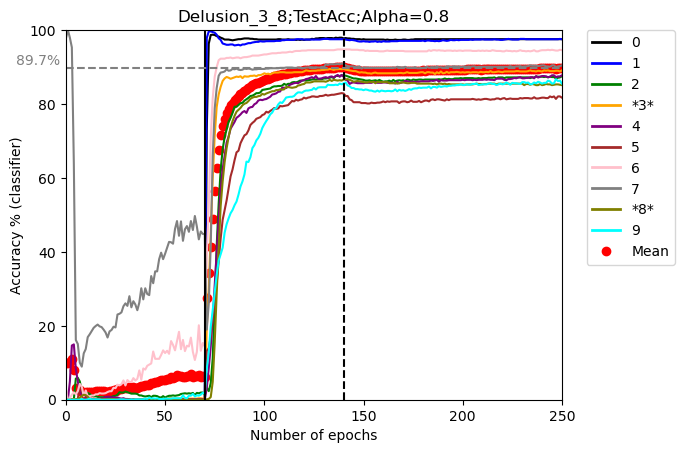

In [62]:
import matplotlib.pyplot as plt
digit_x, digit_y = model.mix_signals

colors = ['black', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']
labels = [f'{i}' for i in range(10)]

fig = plt.figure()
for i in range(10):
    plt.plot(range(num_epochs+1), [epoch_acc[i] for epoch_acc in test_acc], color=colors[i])
mean = [np.mean(list(i.values())) for i in test_acc]
plt.scatter(range(num_epochs+1), mean, color='red')

legend_labels = []
for i, label in enumerate(labels):
    if i == digit_x or i == digit_y:
        # show the swapped digits
        legend_labels.append(f'*{label}*')
    else:
        legend_labels.append(label)
legend_labels.append('Mean')

legend_handles = [plt.Line2D([0], [0], color=color, lw=2) for color in colors]
legend_handles.append(plt.Line2D([0], [0], marker='o', color='red', lw=0, markerfacecolor='red'))

#plt.legend(legend_handles, legend_labels, loc='upper right')
plt.legend(legend_handles, legend_labels, loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)
plt.vlines(70,0, 100, color='black')
plt.vlines(140,0, 100, color='black', linestyle='dashed')

last_test_acc = round(mean[-1], 1)
plt.hlines(last_test_acc, xmin=0, xmax=max(train_counter), colors='grey', linestyles='dashed')
plt.text(-25, last_test_acc +2, f'{last_test_acc}%', fontsize=10, verticalalignment='center', color='grey')

plt.xlabel('Number of epochs')
plt.xlim([0, num_epochs])
plt.ylim([0, 100])
plt.ylabel('Accuracy % (classifier)')
plt.title(f"Delusion_{digit_x}_{digit_y};TestAcc;Alpha={AlphaForEpochSup140}")
#plt.savefig(f'./Plots/Accuracies/Delusion;{digit_x}-{digit_y};TestAcc;Diff_learning;Alpha={AlphaForEpochSup140}.png', dpi=300, bbox_inches='tight')
plt.show()

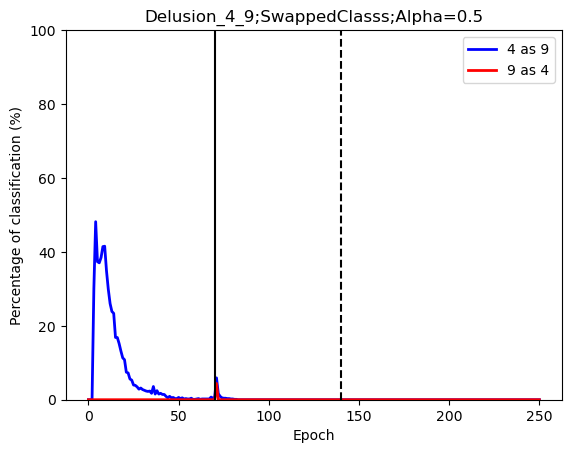

In [48]:
digit_x, digit_y = model.mix_signals

plt.figure()
plt.plot(range(num_epochs+1), [class_epoch[0] for class_epoch in tracked_class], color='blue', linewidth=2)
plt.plot(range(num_epochs+1), [class_epoch[1] for class_epoch in tracked_class], color='red', linewidth=2)
plt.legend([f'{digit_x} as {digit_y}', f'{digit_y} as {digit_x}'])
plt.xlabel('Epoch')
plt.ylabel('Percentage of classification (%)')
plt.ylim(0, 100)
plt.vlines(70,0, 100, color='black')
plt.vlines(140,0, 100, color='black', linestyle='dashed')
plt.title(f"Delusion_{digit_x}_{digit_y};SwappedClasss;Alpha={AlphaForEpochSup140}")
#plt.savefig(f'./Plots/SwappedClasss/Delusion;{digit_x}-{digit_y};SwappedClasss;Diff_learning;Alpha={AlphaForEpochSup140}.png', dpi=300, bbox_inches='tight')
plt.show()

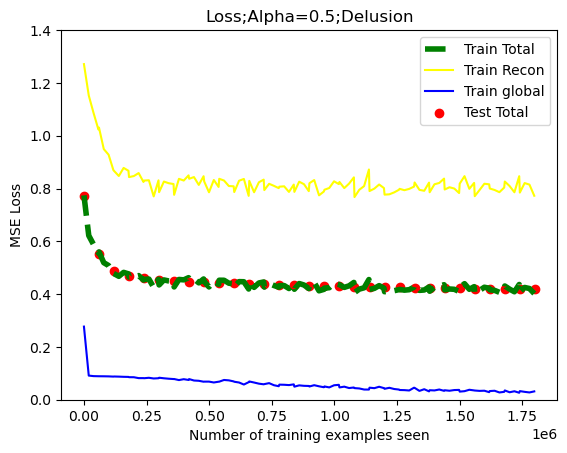

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure()
plt.plot(train_counter, train_losses, color='green', linestyle= 'dashed', linewidth = 4)
plt.plot(train_counter, train_recon_losses, color='yellow')
plt.plot(train_counter, train_global_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.vlines(0.42*10**7,0, 100, color='black')
plt.vlines(0.84*10**7,0, 100, color='black', linestyle='dashed')
plt.legend(['Train Total', 'Train Recon', 'Train global', 'Test Total'], loc='upper right')
plt.xlabel('Number of training examples seen')
plt.ylim([0, 1.4])
plt.ylabel('MSE Loss')
plt.title(f"Delusion_{digit_x}_{digit_y};Alpha={AlphaForEpochSup140};")
plt.savefig(f'./Plots/Losses/Delusion;{digit_x}-{digit_y};Diff_learning;Alpha={AlphaForEpochSup140}.png', dpi=300, bbox_inches='tight')
plt.show()

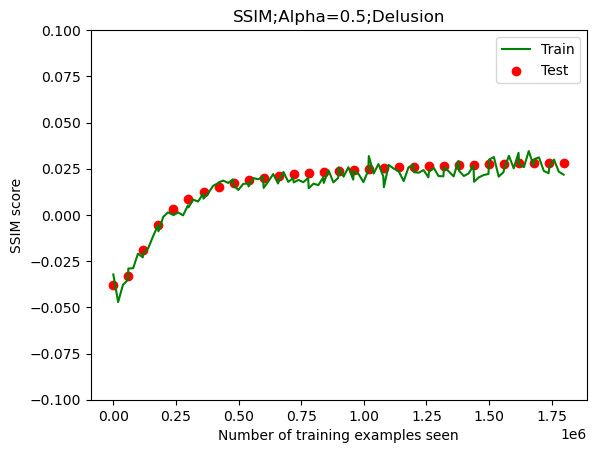

In [ ]:

import matplotlib.pyplot as plt
fig = plt.figure()
plt.plot(train_counter, train_ssim, color='green')
plt.scatter(test_counter, test_ssim, color='red')
plt.legend(['Train','Test'], loc='upper right')
plt.xlabel('Number of training examples seen')
plt.vlines(0.42*10**7, -0.1, 0.2, color='black')
plt.vlines(0.84*10**7, -0.1, 0.2, color='black', linestyle='dashed')
plt.ylim([-0.1, 0.2])
last_test_ssim = round(test_ssim[-1], 3)
plt.hlines(last_test_ssim, xmin=0, xmax=max(train_counter), colors='grey', linestyles='dashed')
plt.text(-2200000, last_test_ssim, f'{last_test_ssim}', fontsize=10, verticalalignment='center', color='grey')
plt.ylabel('SSIM score')
plt.title(f"Delusion_{digit_x}_{digit_y};Alpha={AlphaForEpochSup140}")
plt.savefig(f'./Plots/SSIM/Delusion;{digit_x}-{digit_y};Diff_learning;Alpha={AlphaForEpochSup140}.png', dpi=300, bbox_inches='tight')
plt.show()
